1/1 [==============================] - 0s 78ms/step


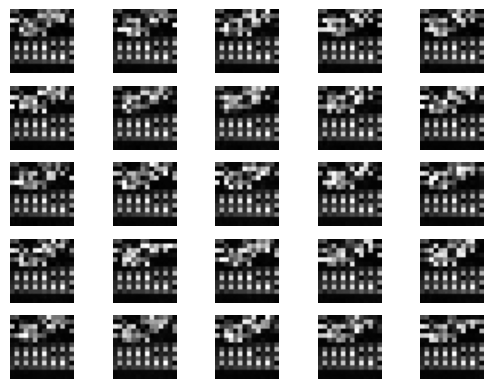

In [91]:
# https://youtu.be/iuQ_f3W5Ttk
"""
Dataset from: Dataset from: https://susanqq.github.io/UTKFace/ 

Latent space is hard to interpret unless conditioned using many classes.​
But, the latent space can be exploited using generated images.​
Here is how...

x Generate 10s of images using random latent vectors.​
x Identify many images within each category of interest (e.g., smiling man, neutral man, etc. )​
x Average the latent vectors for each category to get a mean representation in the latent space (for that category).​
x Use these mean latent vectors to generate images with features of interest. ​

This part of the code is used to generate 128x128x3 images (of faces) using a trained
generator model. 
Alo, faces can be generated using two random latent vectors and interpolated in between.
Finally, the features in the new images can be 'engineered' by doing simple arithmetic
between vectors that are used to generate images. 
In summary, you can find the latent vectors for Smiling Man, neutral face man, 
and a baby with neutral face and then generate a smiling baby face by:
    Smiling Man + Neutral Man - Neutral baby = Smiling Baby
    
"""

from numpy import asarray
from numpy.random import randn
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import os
import sys

# Adicione o caminho do diretório Gan ao sys.path
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
gan_directory = os.path.join(parent_directory, 'GAN')
sys.path.append(gan_directory)

from gan_ip import wasserstein_loss


generator_path = os.path.join(gan_directory, 'models/generator_model50.keras')


#####################################################################
#Let us start by generating images using random latent vectors.
#########################################################################
# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return z_input

# Function to create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :], cmap='gray')
	plt.show()

# load the saved model
model = load_model(generator_path, custom_objects={'wasserstein_loss': wasserstein_loss})
# generate latent vectors to be used as input to the generator
#Here, we are generating 25 latent vectors
latent_points = generate_latent_points(1024, 25)
# generate images using the loaded generator model
X  = model.predict(latent_points)
# plot the generated images. Let us do 5x5 plot as we generated 25 images
plot_generated(X, 5)

In [92]:
import numpy as np

d = 2
w = 16
n = 28
n_meios = int(n / d)

def decode_packets(packet):
    '''Decodes the generated packets
    
    Args:
        generated_packets_dir (string): Path to the directory containing the generated packets
        
    Returns:
        string: Literal representation of the generated packets
    '''
    image = packet
    
    packets = np.zeros((n_meios, n_meios), dtype=np.uint8)

    # Percorrer a imagem, calculando a média de cada submatriz de tamanho dxd
    for i in range(0, n, d):
        for j in range(0, n, d):
            packets[int(i/2), int(j/2)] = int((image[i:i+d, j:j+d].mean()))
    
    packet_in_list = []
    
    for i in range(0, n_meios, 1):
        for j in range(0, n_meios, d):
            packet_in_list.append((str(hex(int(packets[i][j] / 16)).replace('0x', '')) + str(hex(int(packets[i][j+1] / 16)).replace('0x', ''))))

    ipv4 = packet_in_list[0:20]
    icmp = packet_in_list[20:84]

    literal_packet_in_list1 = ''.join(ipv4)
    literal_packet_in_list2 = ''.join(icmp)
    
    return literal_packet_in_list1, literal_packet_in_list2

In [107]:
import binascii
import os

current_dir = os.path.dirname(os.getcwd())
generated_bytes_dir = os.path.join(current_dir, 'generated_ip_bytes_by_gan')
generated_packets_dir = os.path.join(current_dir, 'generated_ip_packets_by_gan')

ipv4_header = []
icmp_header_data = []

if not os.path.exists(generated_packets_dir):
    os.makedirs(generated_packets_dir)

#Global header for pcap 2.4
pcap_global_header = ('D4 C3 B2 A1'   
                      '02 00'         #File format major revision (i.e. pcap <2>.4)  
                      '04 00'         #File format minor revision (i.e. pcap 2.<4>)   
                      '00 00 00 00'     
                      '00 00 00 00'     
                      'FF FF 00 00'     
                      '01 00 00 00')

#pcap packet header that must preface every packet
pcap_packet_header = ('AA 77 9F 47'     
                      '90 A2 04 00'     
                      'XX XX XX XX'   #Frame Size (little endian) 
                      'YY YY YY YY')  #Frame Size (little endian)

eth_header = ('00 00 00 00 00 00'     #Source Mac    
              '00 00 00 00 00 00'     #Dest Mac  
              '08 00')                #Protocol (0x0800 = IP)
                
def getByteLength(str1):
    '''Returns the length of a string in bytes
    
    Args:
        str1 (string): String
        
    Returns:
        integer: Length of the string in bytes
    '''
    return int(len(''.join(str1.split())) / 2)

def writeByteStringToFile(bytestring, filename):
    '''Writes a bytestring to a file
    
    Args:
        bytestring (string): Bytestring to be written to the file
        filename (string): Name of the file to be written
    '''
    bytelist = bytestring.split()  
    bytes = binascii.a2b_hex(''.join(bytelist))
    bitout = open(filename, 'wb')
    bitout.write(bytes)
    
#Splits the string into a list of tokens every n characters
def splitN(str1, n):
    '''Splits the string into a list of tokens every n characters
    
    Args:
        str1 (string): String to be split
        n (integer): Number of characters to split the string
        
    Returns:
        list: List of tokens
    '''
    return [str1[start:start+n] for start in range(0, len(str1), n)]
    
#Calculates and returns the IP checksum based on the given IP Header
def ip_checksum(ip):
    '''Calculates and returns the IP checksum based on the given IP Header
    
    Args:
        ip (string): IP Header
        
    Returns:
        integer: IP checksum
            
    '''
    #split into bytes    
    words = splitN(''.join(ip.split()),4)

    csum = 0
    for word in words:
        csum += int(word, base=16)

    csum += (csum >> 16)
    csum = csum & 0xFFFF ^ 0xFFFF

    return csum

def icmp_checksum(icmp):
    '''Calculates and returns the ICMP checksum based on the given ICMP Header
    
    Args:
        icmp (string): ICMP Header
        
    Returns:
        integer: ICMP checksum
    '''
    words = splitN(''.join(icmp.split()),4)

    csum = 0
    for word in words:
        csum += int(word, base=16)
    

    csum += (csum >> 16)
    csum = csum & 0xFFFF ^ 0xFFFF
    
    return csum

def generatePcapFile(filename, number_of_packets):
    '''Generates a pcap file based on the given filename
    
    Args:
        filename (string): Name of the pcap file to be generated
        
    Returns:
        string: Bytestring of the generated pcap file
    '''
    for i in range(1, number_of_packets + 1):
        icmp_len = getByteLength(icmp_header_data[i-1])
        icmp = icmp_header_data[i-1]
        checksum = icmp_checksum(icmp.replace('XXXX','00 00'))
        icmp = icmp.replace('XXXX',"%04x"%checksum)
        
        ip_len = icmp_len + getByteLength(ipv4_header[i-1])
        ip = ipv4_header[i-1].replace('XXXX',"%04x"%ip_len)
        checksum = ip_checksum(ip.replace('YYYY','00 00'))
        ip = ip.replace('YYYY',"%04x"%checksum)
        
        pcap_len = ip_len + getByteLength(eth_header)
        hex_str = "%08x"%pcap_len
        reverse_hex_str = hex_str[6:] + hex_str[4:6] + hex_str[2:4] + hex_str[:2]
        pcaph = pcap_packet_header.replace('XX XX XX XX',reverse_hex_str)
        pcaph = pcaph.replace('YY YY YY YY',reverse_hex_str)
            
        if i == 1:
            bytestring = pcap_global_header + pcaph + eth_header + ip + icmp
        else:
            bytestring += pcaph + eth_header + ip + icmp
    
    
    output_path = os.path.join(generated_packets_dir, filename)
    
    writeByteStringToFile(bytestring, output_path)
    
    
def image_to_packet(packets, number_of_packets):
    for i in range(1, number_of_packets + 1):
        literal_lista1, literal_lista2 = decode_packets(packets[i-1])

        ipv4_header.append(literal_lista1[0:4] + 'XX' 'XX' + literal_lista1[8:20] + 'YY' 'YY' + literal_lista1[24:40])
        icmp_header_data.append(literal_lista2[0:4] + 'XX' 'XX' + literal_lista2[8:16] + literal_lista2[48:128])
        
        print("Packet " + str(i) + " generated!")
                      
    pcapfile = 'adadfgqradq' + '.pcap'
        
    generatePcapFile(pcapfile, number_of_packets)
    print("Pcap file generated!")
    print(generated_packets_dir)

1/1 [==============================] - 0s 81ms/step


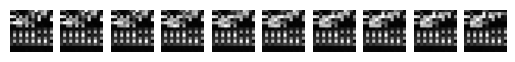

Packet 1 generated!
Packet 2 generated!
Packet 3 generated!
Packet 4 generated!
Packet 5 generated!
Packet 6 generated!
Packet 7 generated!
Packet 8 generated!
Packet 9 generated!
Packet 10 generated!
Pcap file generated!
/home/pre9o/PAC-GAN/TESTES/generated_ip_packets_by_gan


In [94]:
#####################################################################
#Now, let us generate 2 latent vectors and interpolate between them.
#Let us do linear interpolation although in reality the latent space is curved. 
#Interpolating between faces - Linear interpolation
#################################################################

from email.mime import image
from numpy import linspace

# Function to generate random latent points
#Same as defined above, re-defining for convenience. 
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
    return z_input

# Interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate between points (e.g., between 0 and 1 if you divde to 10 then you have 0.111, 0.222, etc.)
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolation of vectors based on the above interpolation ratios
    vectors = list()
    for ratio in ratios:
            v = (1.0 - ratio) * p1 + ratio * p2
            vectors.append(v)
    return asarray(vectors)

    # create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n):
            plt.subplot(1, n, 1 + i)
            plt.axis('off')
            plt.imshow(examples[i, :, :], cmap='gray')
    plt.show()
    image_to_packet(examples, n)

# load the model, if you haven't already loaded it above. 
model = load_model(generator_path, custom_objects={'wasserstein_loss': wasserstein_loss})
# generate points in latent space
#Let us generate 2 latent points between which we will interpolate
pts = generate_latent_points(1024, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images using the interpolated latent points
X = model.predict(interpolated)
X = (X + 1) * 127.5
X = X.astype(np.uint8)
# plot the result
plot_generated(X, len(interpolated))

4/4 [==============================] - 0s 4ms/step
Packet 1 generated!
Packet 2 generated!
Packet 3 generated!
Packet 4 generated!
Packet 5 generated!
Packet 6 generated!
Packet 7 generated!
Packet 8 generated!
Packet 9 generated!
Packet 10 generated!
Packet 11 generated!
Packet 12 generated!
Packet 13 generated!
Packet 14 generated!
Packet 15 generated!
Packet 16 generated!
Packet 17 generated!
Packet 18 generated!
Packet 19 generated!
Packet 20 generated!
Packet 21 generated!
Packet 22 generated!
Packet 23 generated!
Packet 24 generated!
Packet 25 generated!
Packet 26 generated!
Packet 27 generated!
Packet 28 generated!
Packet 29 generated!
Packet 30 generated!
Packet 31 generated!
Packet 32 generated!
Packet 33 generated!
Packet 34 generated!
Packet 35 generated!
Packet 36 generated!
Packet 37 generated!
Packet 38 generated!
Packet 39 generated!
Packet 40 generated!
Packet 41 generated!
Packet 42 generated!
Packet 43 generated!
Packet 44 generated!
Packet 45 generated!
Packet 46 gen

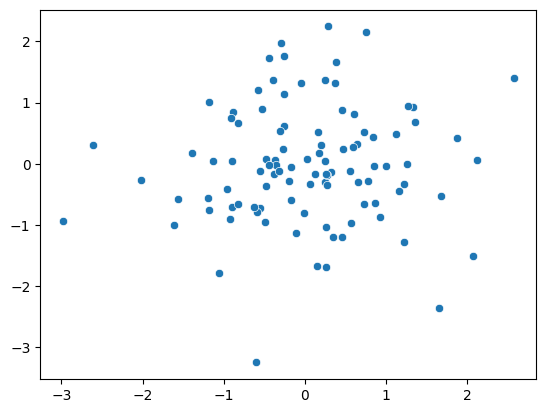

In [106]:
################################################################
#Now, let us perform arithmetic with latent points so we can generate faces
#with features of interest. 
#To work with latent points we must first generate a bunch of faces and 
#save them along with their corresponding latent points. This can be used
#to visually locate images of interest and thus identify the latent points.
#For example, latent points corresponding to baby face or sun glasses, etc. 
###########################################################

from numpy import mean, expand_dims
# example of loading the generator model and generating images

# Function to generate random latent points
#Same as defined above, re-defining for convenience. 
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return z_input

# create a plot of generated images and save for easy visualization
def plot_generated(examples, n, p):
    plt.figure(figsize=(16, 16))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :], cmap='gray')
    plt.savefig('generated_packets.png')
    plt.close()
    
    image_to_packet(examples, p)

# load the model, if you haven't already loaded it above
model = load_model(generator_path, custom_objects={'wasserstein_loss': wasserstein_loss})

# generate points in latent space that we can use to generate some images
#We then identify some images with our features of interest and locate thir corresponding latent vectors
latent_points = generate_latent_points(1024, 100)

#Plot the latent points to see that they are spread around and we have no clue how to interpret them. 
import seaborn as sns
sns.scatterplot(x=latent_points[:, 0], y=latent_points[:, 1])

# generate images using the latent points. 
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1] for plotting
X = (X + 1) * 127.5
X = X.astype(np.uint8)
# plot and save generated images
plot_generated(X, 10, 100)


[-0.66279521  0.23645366 -0.05910649 ...  0.18859098  0.5448367
 -0.42779845]
1/1 [==============================] - 0s 17ms/step


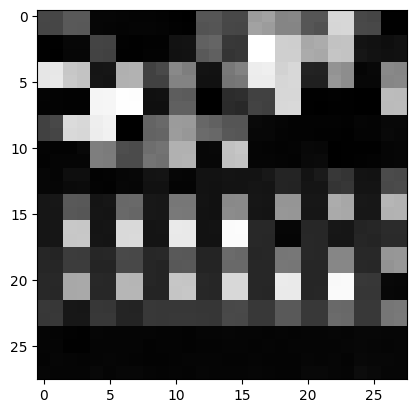

Packet 1 generated!
Pcap file generated!
/home/pre9o/PAC-GAN/TESTES/generated_ip_packets_by_gan


In [112]:
#Now, identify images corresponding to a specific type.
#e.g. all baby face images, smiling man images, 
# smiling man - neutral man + baby face = smiling baby

# retrieve specific points
#Now, identify images corresponding to a specific type.
#Start counting from 1 as we are going to offset our image number later, by subtracting 1.
#e.g. all baby face images, smiling man images, 
# smiling man - neutral man + baby face = smiling baby
#OR try adult with glasses  - adult no glasses + baby no glasses

#Identify a few images from classes of interest
# smiling_man_ix = [1, 10, 16, 26, 27, 28]
# neutral_man_ix = [16, 95, 63]
# baby_ix = [13,26,28,93,94]
primeiros_bytes_menores_que_cinquenta = [35, 85, 12, 35, 37, 67, 75, 78, 85]
primeiros_bytes_menores_que_cem = [19, 59, 81]
#baby_no_glasses = [15,20]
primeiros_bytes_maiores_que_cento_e_setenta_e_dois = [14, 45, 63, 65, 69, 96]
#person_no_lipstick = [1, 4, 9, 15]

#Reassign classes of interest to new variables... just to make it easy not
# to change names all the time we get interested in new features. 
feature1_ix = primeiros_bytes_menores_que_cinquenta
feature2_ix = primeiros_bytes_menores_que_cem
feature3_ix = primeiros_bytes_maiores_que_cento_e_setenta_e_dois

# Function to average list of latent space vectors to get the mean for a given type
def average_points(points, ix):
	# subtract 1 from image index so it matches the image from the array
    # we are doing this as our array starts at 0 but we started counting at 1. 
	zero_ix = [i-1 for i in ix]
	# retrieve required vectors corresponding to the selected images
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	
	return avg_vector

# average vectors for each class
feature1 = average_points(latent_points, feature1_ix)
feature2 = average_points(latent_points, feature2_ix)
feature3 = average_points(latent_points, feature3_ix)

# Vector arithmetic....
result_vector = feature1 - feature2 + feature3
print(result_vector)

# generate image using the new calculated vector
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)

# scale pixel values for plotting
result_image = (result_image + 1) / 2.0
plt.imshow(result_image[0], cmap='gray')
plt.show()
image_to_packet(result_image, 1)